In [1]:
import numpy as np
from skimage.draw import line
from skimage.morphology import thin
import matplotlib.pyplot as plt
import xml.etree.ElementTree as ET


In [2]:

def get_traces_data(inkml_file_abs_path, xmlns='{http://www.w3.org/2003/InkML}'):

    traces_data = []

    tree = ET.parse(inkml_file_abs_path)
    root = tree.getroot()
    # doc_namespace = "{http://www.w3.org/2003/InkML}"
    doc_namespace = xmlns

    'Stores traces_all with their corresponding id'
    traces_all = [{'id': trace_tag.get('id'),
                   'coords': [[round(float(axis_coord)) if float(axis_coord).is_integer() else round(float(axis_coord) * 10000)
                               for axis_coord in coord[1:].split(' ')] if coord.startswith(' ')
                              else [round(float(axis_coord)) if float(axis_coord).is_integer() else round(float(axis_coord) * 10000)
                                    for axis_coord in coord.split(' ')]
                              for coord in (trace_tag.text).replace('\n', '').split(',')]}
                  for trace_tag in root.findall(doc_namespace + 'trace')]

    'Sort traces_all list by id to make searching for references faster'
    traces_all.sort(key=lambda trace_dict: int(trace_dict['id']))

    'Always 1st traceGroup is a redundant wrapper'
    traceGroupWrapper = root.find(doc_namespace + 'traceGroup')

    if traceGroupWrapper is not None:
        for traceGroup in traceGroupWrapper.findall(doc_namespace + 'traceGroup'):

            label = traceGroup.find(doc_namespace + 'annotation').text

            'traces of the current traceGroup'
            traces_curr = []
            for traceView in traceGroup.findall(doc_namespace + 'traceView'):

                'Id reference to specific trace tag corresponding to currently considered label'
                traceDataRef = int(traceView.get('traceDataRef'))

                'Each trace is represented by a list of coordinates to connect'
                single_trace = traces_all[traceDataRef]['coords']
                traces_curr.append(single_trace)

            traces_data.append({'label': label, 'trace_group': traces_curr})

    else:
        'Consider Validation data that has no labels'
        [traces_data.append({'trace_group': [trace['coords']]})
         for trace in traces_all]

    return traces_data


def convert_to_imgs(traces_data, box_size=int(100)):

    patterns_enc = []
    classes_rejected = []

    for pattern in traces_data:

        trace_group = pattern['trace_group']

        'mid coords needed to shift the pattern'
        min_x, min_y, max_x, max_y = get_min_coords(trace_group)

        'traceGroup dimensions'
        trace_grp_height, trace_grp_width = max_y - min_y, max_x - min_x

        'shift pattern to its relative position'
        shifted_trace_grp = shift_trace_grp(
            trace_group, min_x=min_x, min_y=min_y)

        'Interpolates a pattern so that it fits into a box with specified size'
        'method: LINEAR INTERPOLATION'
        try:
            interpolated_trace_grp = interpolate(shifted_trace_grp,
                                                 trace_grp_height=trace_grp_height, trace_grp_width=trace_grp_width, box_size=box_size - 1)
        except Exception as e:
            print(e)
            print('This data is corrupted - skipping.')
            classes_rejected.append(pattern.get('label'))

            continue

        'Get min, max coords once again in order to center scaled patter inside the box'
        min_x, min_y, max_x, max_y = get_min_coords(interpolated_trace_grp)

        centered_trace_grp = center_pattern(
            interpolated_trace_grp, max_x=max_x, max_y=max_y, box_size=box_size)

        'Center scaled pattern so it fits a box with specified size'
        pattern_drawn = draw_pattern(centered_trace_grp, box_size=box_size)
        # Make sure that patterns are thinned (1 pixel thick)
        pat_thinned = 1.0 - thin(1.0 - np.asarray(pattern_drawn))
        plt.imshow(pat_thinned, cmap='gray')
        plt.show()
        pattern_enc = dict(
            {'features': pat_thinned, 'label': pattern.get('label')})

        # Filter classes that belong to categories selected by the user
#             if pattern_enc.get('label') in self.classes:

        patterns_enc.append(pattern_enc)

    return patterns_enc, classes_rejected


def get_min_coords(trace_group):

    min_x_coords = []
    min_y_coords = []
    max_x_coords = []
    max_y_coords = []

    for trace in trace_group:

        x_coords = [coord[0] for coord in trace]
        y_coords = [coord[1] for coord in trace]

        min_x_coords.append(min(x_coords))
        min_y_coords.append(min(y_coords))
        max_x_coords.append(max(x_coords))
        max_y_coords.append(max(y_coords))

    return min(min_x_coords), min(min_y_coords), max(max_x_coords), max(max_y_coords)


def shift_trace_grp(trace_group, min_x, min_y):

    shifted_trace_grp = []

    for trace in trace_group:
        shifted_trace = [[coord[0] - min_x, coord[1] - min_y]
                         for coord in trace]

        shifted_trace_grp.append(shifted_trace)

    return shifted_trace_grp


def interpolate(trace_group, trace_grp_height, trace_grp_width, box_size):

    interpolated_trace_grp = []

    if trace_grp_height == 0:
        trace_grp_height += 1
    if trace_grp_width == 0:
        trace_grp_width += 1

    '' 'KEEP original size ratio' ''
    trace_grp_ratio = (trace_grp_width) / (trace_grp_height)

    scale_factor = 1.0
    '' 'Set \"rescale coefficient\" magnitude' ''
    if trace_grp_ratio < 1.0:

        scale_factor = (box_size / trace_grp_height)
    else:

        scale_factor = (box_size / trace_grp_width)

    for trace in trace_group:
        'coordintes convertion to int type necessary'
        interpolated_trace = [
            [round(coord[0] * scale_factor), round(coord[1] * scale_factor)] for coord in trace]

        interpolated_trace_grp.append(interpolated_trace)

    return interpolated_trace_grp


def get_min_coords(trace_group):

    min_x_coords = []
    min_y_coords = []
    max_x_coords = []
    max_y_coords = []

    for trace in trace_group:

        x_coords = [coord[0] for coord in trace]
        y_coords = [coord[1] for coord in trace]

        min_x_coords.append(min(x_coords))
        min_y_coords.append(min(y_coords))
        max_x_coords.append(max(x_coords))
        max_y_coords.append(max(y_coords))

    return min(min_x_coords), min(min_y_coords), max(max_x_coords), max(max_y_coords)


def center_pattern(trace_group, max_x, max_y, box_size):

    x_margin = int((box_size - max_x) / 2)
    y_margin = int((box_size - max_y) / 2)

    return shift_trace_grp(trace_group, min_x=-x_margin, min_y=-y_margin)


def draw_pattern(trace_group, box_size):

    pattern_drawn = np.ones(shape=(box_size, box_size), dtype=np.float32)
    for trace in trace_group:

        ' SINGLE POINT TO DRAW '
        if len(trace) == 1:
            x_coord = trace[0][0]
            y_coord = trace[0][1]
            pattern_drawn[y_coord, x_coord] = 0.0

        else:
            ' TRACE HAS MORE THAN 1 POINT '

            'Iterate through list of traces endpoints'
            for pt_idx in range(len(trace) - 1):
                print(pt_idx, trace[pt_idx])

                'Indices of pixels that belong to the line. May be used to directly index into an array'
                pattern_drawn[line(r0=int(trace[pt_idx][1]), c0=int(trace[pt_idx][0]),
                                   r1=int(trace[pt_idx + 1][1]), c1=int(trace[pt_idx + 1][0]))] = 0

    return pattern_drawn


def inkml2img(input_path, output_path, color='black'):
    traces = get_traces_data(input_path)
    for elem in traces:
        ls = elem['trace_group']
        for subls in ls:
            data = np.array(subls)
            x, y = zip(*data)
            plt.plot(x, y, linewidth=2, c=color)
    plt.gca().invert_yaxis()
    plt.gca().set_aspect('equal', adjustable='box')
    plt.gca().get_xaxis().set_visible(False)
    plt.gca().get_yaxis().set_visible(False)
    plt.gca().spines['top'].set_visible(False)
    plt.gca().spines['right'].set_visible(False)
    plt.gca().spines['bottom'].set_visible(False)
    plt.gca().spines['left'].set_visible(False)
    plt.savefig(output_path, bbox_inches='tight', dpi=100)
    plt.gcf().clear()


ValueError: Format 'json' is not supported (supported formats: eps, jpeg, jpg, pdf, pgf, png, ps, raw, rgba, svg, svgz, tif, tiff, webp)

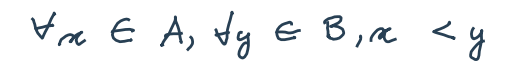

In [11]:

if __name__ == "__main__":
    import sys
    input_inkml = 'C:\\Users\\Anubhab Bose\\Desktop\\Deep Learning Project\\Junk\\data\\CROHME_full_v2\\CROHME2012_data\\testDataGT\\001-equation002.inkml'
    output_path = sys.argv[2]
    inkml2img(input_inkml, output_path, color='#284054')